# Overview

### In this notebook, the following `dimensionality reduction techniques` (listed below) are applied `DIRECTLY` to the `raw dataset`.
- **Principal Component Analysis (PCA)**, 
- **Kernel Principal Component Analysis (kPCA)**, 
- **Truncated Singular Value Decomposition (tSVD)**, 
- **Non-Negative Matrix Factorization (NMF)**, 
- **Factor Analysis (FA)**, 
- **Fast Independent Component Analysis (fICA)**,
- ****Incremental Principal Component Analysis (iPCA)**,
- **Sparse Principal Component Analysis (sPCA)**,
- **T-distributed Stochastic Neighbor Embedding (t-SNE)**, 
- **Spectral Embedding (SE)**, 
- **Isometric Mapping (Isomap)**, 
- **Locally Linear Embedding (LLE)**, 
- **Multidimensional scaling (MDS)**,
- **Multiple Correspondence Analysis (MCA)**,
- **Uniform Manifold Approximation and Projection (UMAP)**,
- **Dictionary Learning (DL)**

### Also, the following `performance metrics` (listed below) are computed to evaluate the performance of each dimentionality reduction technique.

- **adjusted rand score**,
- **normalized mutual info score**,
- **homogeneity score**:,
- **completeness score**,
- **v_measure score**,
- **silhouette score**

### Finaly, the decomposed datasets are plotted to visualize the boundary between the two classes.

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

# Import the necessary library

In [2]:
# Data and Plotting
import pandas as pd
import numpy as np
from pandas.plotting import andrews_curves, parallel_coordinates
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
import seaborn as sns

# Data encoding and Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, Normalizer, KBinsDiscretizer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# Dimensionality Reduction and Clustering Algorithms
from sklearn.decomposition import PCA, KernelPCA, TruncatedSVD, NMF, FactorAnalysis, SparsePCA
from sklearn.decomposition import DictionaryLearning, IncrementalPCA, FastICA
from sklearn.manifold import TSNE, SpectralEmbedding, Isomap, LocallyLinearEmbedding, MDS
from prince import MCA,FAMD
from umap import UMAP
from sklearn.cluster import KMeans

# Noise Filtering and Anomaly Detection
from sklearn.ensemble import IsolationForest

# Custom Transformer
from sklearn.base import BaseEstimator, TransformerMixin

# Data spliting and Cross Validation
from sklearn.model_selection import train_test_split as tts, StratifiedKFold, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate, KFold

# Performance Metrics
from sklearn.metrics import completeness_score, homogeneity_score, v_measure_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

%matplotlib notebook

# Load the dataset

### Approach 1: Load the data from the uc irvine machine learning repository using api

In [3]:
# # fetch dataset 
# differentiated_thyroid_cancer_recurrence = fetch_ucirepo(id=915) 
  
# # data (as pandas dataframes) 
# X = differentiated_thyroid_cancer_recurrence.data.features 
# y = differentiated_thyroid_cancer_recurrence.data.targets 
  
# # metadata 
# print(differentiated_thyroid_cancer_recurrence.metadata) 
  
# # variable information 
# print(differentiated_thyroid_cancer_recurrence.variables)

### Approach 2: Load from the downloaded Dataset

In [4]:
data = pd.read_csv("Thyroid_Diff.csv")

X = data.drop("Recurred", axis=1)
y = data["Recurred"]
y = y.map({"No":0,"Yes":1})
# data.head(2)

In [5]:
data["Recurred"].value_counts()

Recurred
No     275
Yes    108
Name: count, dtype: int64

# Split data into train and test sets

In [6]:
# X_train, X_test, y_train, y_test = tts(X, 
#                                        y, 
#                                        train_size=.7, 
#                                        random_state=123,
#                                       )
# y_train.value_counts()

# Apply Various Dimensionality Reduction Techniques and Evaluate With CV

In [7]:
# Define the preprocessor
num_features = list(X.columns[:1])
cat_features = list(X.columns[1:])

# Define the numerical transformer
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
    ("scaler", MinMaxScaler())
    # ('scaler', Normalizer()),  
])

# Define the categorical transformer
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown="ignore"))  
])

# Define your ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ],
    remainder="passthrough",
)

# Define the clustering algorithm
kmeans = KMeans(n_clusters=2, n_init="auto", random_state=123)

In [9]:
# Custom Transformer for DataFrame Conversion (Specifically for MCA). This is because MCA does not accept numpy ndarray as 
# input

class ToDataFrame(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.columns = None

    def fit(self, X, y=None):
        self.columns = self._generate_column_names(X)
        return self

    def transform(self, X):
        return pd.DataFrame(X, columns=self.columns)
    
    def _generate_column_names(self, X):
        return [f'feature_{i}' for i in range(X.shape[1])]
    
    
# Define the dimensionality reducers
n_comp = 3
decomposers =[
    # Decomposition Techniques   
#     ("MCA", MCA(n_components=n_comp)),
    ("PCA", PCA(n_components=n_comp)),
#     ("sPCA", SparsePCA(n_components=n_comp)),
#     ("kPCA", KernelPCA(n_components=n_comp, kernel="rbf")),
    ("fICA", FastICA(n_components=n_comp, max_iter=1000)),
#     ("iPCA", IncrementalPCA(n_components=n_comp)),
    ("tSVD", TruncatedSVD(n_components=n_comp)),
    ("NMF", NMF(n_components=n_comp, max_iter=1000)),
#     ("DL", DictionaryLearning(n_components=n_comp)),
#     ("FA", FactorAnalysis(n_components=n_comp)),
    # Manifold Learning Techniques     
    ("UMAP", UMAP(n_components=n_comp)),
    ("t-NSE", TSNE(n_components=n_comp)),
#     ("SE", SpectralEmbedding(n_components=n_comp)),
    ("Isomap", Isomap(n_components=n_comp)),
    ("LLE", LocallyLinearEmbedding(n_components=n_comp)),
#     ("MDS", MDS(n_components=n_comp, normalized_stress="auto")),
]

# Define the scorers
scorers = {
    "ARI": "adjusted_rand_score",
#     "AMI": "adjusted_mutual_info_score",
#     "Homogeneity Score": "homogeneity_score",
#     "Completeness Score": "completeness_score",
    "V-Measure": "v_measure_score",
    "Silhouette Score": "silhouette_score"
}

n_splits = 10
col_names = [f"PC{i}" for i in range(1, n_comp + 1)]
skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
y = np.array(y)

reduced_datas = {}

# Run cross-validation and collect performance metrics
for decomposer_name, decomposer in decomposers:
    
    print(f"\rRunning {n_splits}-fold CV for {decomposer_name}...", end="", flush=True)
    
    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("to_dataframe", ToDataFrame()),
            ("decomposer", decomposer),
        ]
    )
    
    X_reduced = pipeline.fit_transform(X)
        
    # assert not np.any(np.isnan(X_reduced))
    # assert np.all(np.isfinite(X_reduced))
    
    metrics = {metric_name: metric for metric_name, metric in scorers.items() if metric_name != "Silhouette Score"}
    cv_results = cross_validate(kmeans, X_reduced, y, cv=skf, scoring=metrics, return_train_score=False)
    
    # Handle silhouette score separately
    kmeans.fit(X_reduced)
    y_pred = kmeans.predict(X_reduced)
    avg_silhouette = silhouette_score(X_reduced, y_pred)
    
    # Compute the Kmean centroids
    centroids = {"centroids": kmeans.cluster_centers_}
    
    metric_ids = [metric_id for metric_id in cv_results.keys() if metric_id.startswith("test_")]
    scores = {name: cv_results[metric_id] for name, metric_id in zip(scorers.keys(), metric_ids)}
    scores["Silhouette Score"] = [avg_silhouette]
    
    if decomposer_name == "MCA":
        df_reduced = X_reduced.copy()
        df_reduced.columns = col_names
    else:
        df_reduced = pd.DataFrame(X_reduced, columns=col_names)
        
    df_reduced.to_csv(f"../generated datasets/{decomposer_name} generated data.csv")
    
    df_reduced["Recurred"] = y

    # assert not df_reduced["Recurred"].isna().any()
    
    reduced_datas[decomposer_name] = (scores, centroids, df_reduced)
    
    print(f"\rCompleted {n_splits}-fold CV for {decomposer_name}")

print(f"\rAll {n_splits}-fold CV Completed")

Completed 10-fold CV for PCA.
Completed 10-fold CV for fICA.
Completed 10-fold CV for tSVD.
Completed 10-fold CV for NMF.
Completed 10-fold CV for UMAP.
Completed 10-fold CV for t-NSE.
Completed 10-fold CV for Isomap.
Completed 10-fold CV for LLE.
All 10-fold CV Completed


# Extract the first principal components (PC1s) from each engineered feature

In [10]:
PC1s = []
reducers = []
for reducer_name, (metrics, centroids, data) in reduced_datas.items():
    reducers.append(reducer_name)
    PC1s.append(data["PC1"])
    
# scaler = StandardScaler()
# X = scaler.fit_transform(PC1s)
    
df_pc1s = pd.DataFrame(PC1s).T
df_pc1s.columns = reducers
df_pc1s.head(4)

,PCA,fICA,tSVD,NMF,UMAP,t-NSE,Isomap,LLE
0,-0.853174,0.194668,3.171897,0.000000,9.708470,-28.634314,-6.646588,-0.001011
1,-0.978265,0.110088,3.082299,0.000000,9.237868,-39.881805,-7.609954,-0.001322
2,-1.288670,0.069433,3.365014,0.113915,10.024277,-32.946190,-6.413668,-0.001058
3,-1.263177,0.137800,3.420876,0.107696,10.083591,-40.428535,-6.492121,-0.001057


# Compute the variance of each PC1

In [11]:
df_pc1s.std()

PCA        1.200004
fICA       1.001308
tSVD       0.537315
NMF        0.156005
UMAP       3.907238
t-NSE     22.645169
Isomap     4.477402
LLE        0.049429
dtype: float64

# Organize the performance metrics in a dataframe for easy visualization

In [13]:
performance_metrics = {scorer_name: [] for scorer_name in scorers.keys()}

for reducer_name, result in reduced_datas.items():
    for scorer_name, score in result[0].items():
        # print(score)
        performance_metrics[scorer_name].append(np.mean(score))

df_performance = pd.DataFrame(performance_metrics)
df_performance.insert(0, "Dim. red. Techniques", [reducer_name for reducer_name in reduced_datas])   
df_performance["PC1 Variance"] = list(df_pc1s.std())
df_performance = df_performance.round(3)

df_performance.to_csv("../results/Dimensionality Reduction Techniques Performance Metrics.csv", index=False)
df_performance

,Dim. red. Techniques,ARI,V-Measure,Silhouette Score,PC1 Variance
0,PCA,0.573,0.470,0.489,1.200
1,fICA,0.226,0.200,0.318,1.001
2,tSVD,0.567,0.455,0.537,0.537
3,NMF,0.007,0.089,0.352,0.156
4,UMAP,-0.088,0.092,0.617,3.907
5,t-NSE,0.290,0.318,0.352,22.645
6,Isomap,0.241,0.291,0.334,4.477
7,LLE,-0.087,0.092,0.629,0.049


# Visualize the Decomposed datasets

# 2D Scatter Plots of the Decomposed Dataset 

**The cluster demacations are based on the ground truth and NOT the kmeans predicted clusters while the cluster centroids are those predicted by Kmeans**

<IPython.core.display.Javascript object>


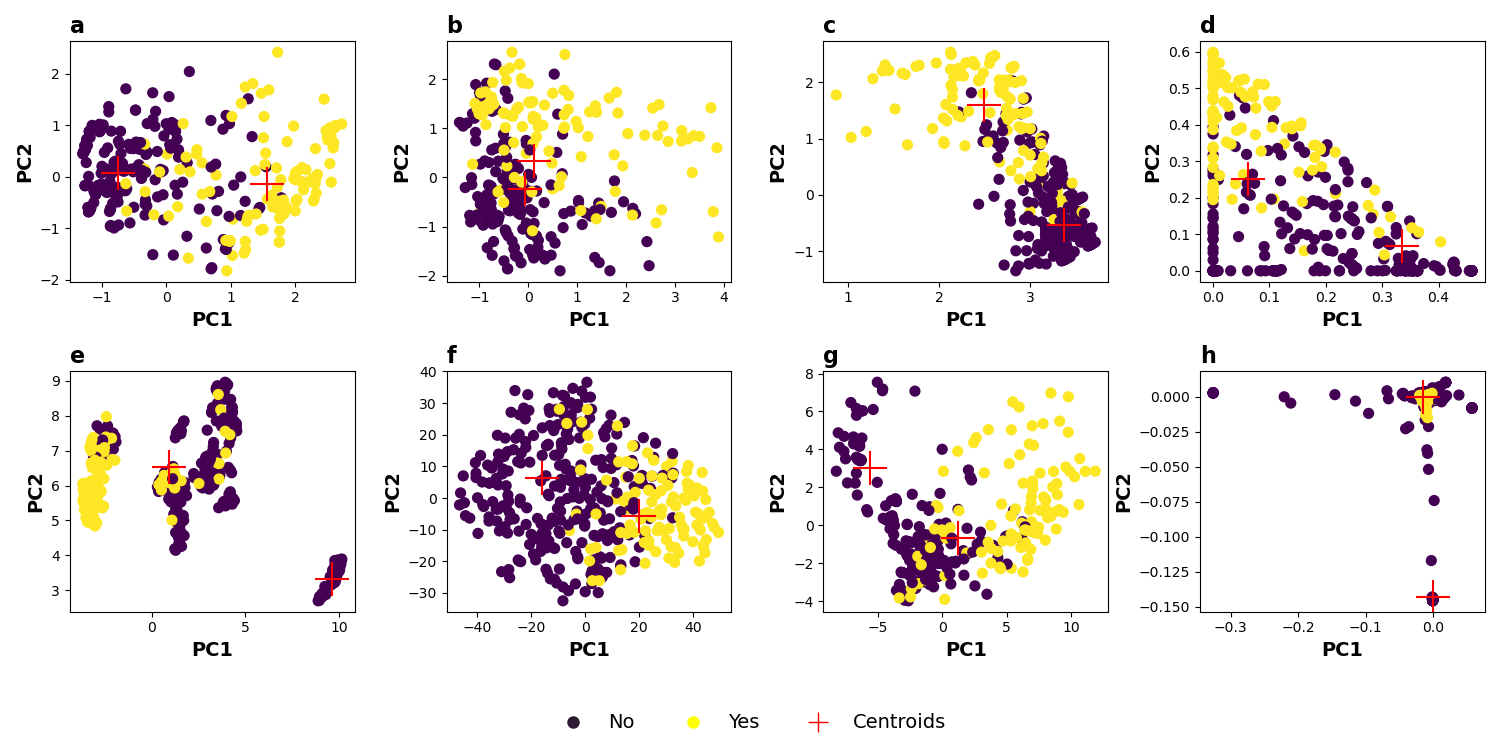

In [14]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

figsize = (15, 7.5)
nrows, ncols = 2, 4
titles = ["a", "b", "c", "d", "e", "f", "g", "h"]
fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
axes = axes.flatten()

for ax, title, (reducer_name, (metrics, centroids, data)) in zip(axes, titles, reduced_datas.items()):
    scatter = ax.scatter(data["PC1"], data["PC2"], c=data["Recurred"], cmap="viridis", marker="o", s=50)
    centroids = centroids["centroids"]
    ax.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='+', s=600, label='Centroids')
    ax.set_title(title, loc="left", fontweight="bold", fontsize=16)
    ax.set_xlabel("PC1", fontweight="bold", fontsize=14)
    ax.set_ylabel("PC2", fontweight="bold", fontsize=14)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='No', markerfacecolor='#301934', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Yes', markerfacecolor='yellow', markersize=10),
    Line2D([0], [0], marker='+', color='red', label='Centroids', markersize=15, linestyle='None')
]

fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=14, frameon=False)

fig.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust layout to make space for the legend
plt.savefig("../results/DecomposedData 2D-Scatter Plots.png", dpi=800)
plt.show()


# Distribution & Heatmap of the first principal components from the best datasets of each data engineering technique 

In [15]:
PC1s = []
for reducer_name, (metrics, centroids, data) in reduced_datas.items():
    PC1s.append(data["PC1"])
    
scaler = StandardScaler()
X = scaler.fit_transform(PC1s)
df = pd.DataFrame(X).T
df.columns = titles
df

,a,b,c,d,e,f,g,h
0,0.191040,0.289683,0.569957,0.271357,1.185305,-2.424255,-0.354348,0.271262
1,0.250810,0.328207,0.539572,0.320378,0.977319,-2.515772,-0.220796,0.320284
2,0.174934,0.288285,0.563343,0.291997,1.119144,-2.467291,-0.252813,0.282401
3,0.212186,0.309933,0.538996,0.307833,1.003858,-2.520409,-0.152641,0.300245
4,0.236124,0.241130,0.588768,0.280653,1.125047,-2.455202,-0.297055,0.280534
...,...,...,...,...,...,...,...,...
378,-0.392870,-0.252656,-0.428813,-0.509175,-0.749412,2.533161,0.312259,-0.512494
379,-0.319653,-0.283564,-0.409652,-0.508322,-0.751401,2.552484,0.229011,-0.508904
380,-0.306170,-0.264936,-0.407607,-0.515400,-0.778710,2.543942,0.244904,-0.516023
381,-0.308926,-0.234285,-0.440791,-0.512857,-0.803462,2.530352,0.283522,-0.513554


<IPython.core.display.Javascript object>


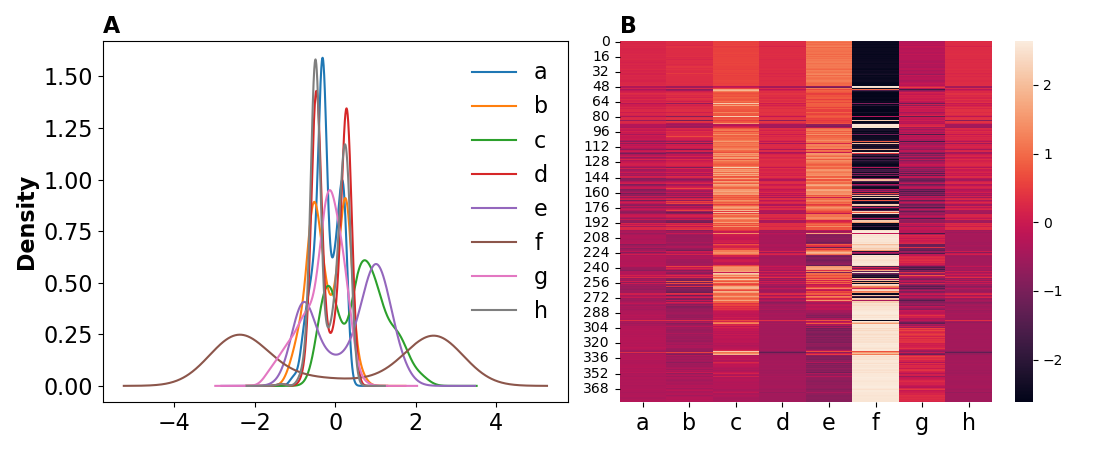

In [16]:
figsize = (11, 4.5)          
nrows, ncols = 1, 2

fig, axes = plt.subplots(1,2, figsize=figsize)

df.plot(kind="density", ax=axes[0], )
axes[0].set_title("A", loc="left", fontweight="bold", fontsize=16)
axes[0].tick_params(axis="both", which="major", labelsize=16)
axes[0].set_ylabel("Density", fontweight="bold", fontsize=16)
axes[0].legend(fontsize=16, frameon=False)

sns.heatmap(df, ax=axes[1])
axes[1].set_title("B", loc="left", fontweight="bold", fontsize=16)
axes[1].tick_params(axis="x", which="major", labelsize=16)
axes[1].tick_params(axis="y", which="major", labelsize=10)
# plt.setp(axes[1].get_xticklabels(), fontweight="bold")

fig.tight_layout()
plt.savefig("../results/Distribution Heatmap Plots of PC1s from each data decomposition technique.png", dpi=800)
plt.show()